# Library


In [102]:
import re
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print
from rich.table import Table
from rich.console import Console

## `LRMFV` extraction


In [103]:
df = pd.read_csv("coding_retail.csv")
retaildf = pd.DataFrame(df)
display(retaildf)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Quantity_Group,Country_Group,InvoiceMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,Small (6-50),UK,December
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,Small (6-50),UK,December
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,Small (6-50),UK,December
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,Small (6-50),UK,December
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,Small (6-50),UK,December
...,...,...,...,...,...,...,...,...,...,...,...,...
805615,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,Small (6-50),Europe,December
805616,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,Very Small (1-5),Europe,December
805617,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,Very Small (1-5),Europe,December
805618,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,Very Small (1-5),Europe,December


In [104]:
country_dummies = pd.get_dummies(
    retaildf["Country_Group"], prefix="D"
)  # pilih country group utk di OHE
retaildf = pd.concat([retaildf, country_dummies], axis=1)  # merge ke retaildf

retaildf["InvoiceDate"] = pd.to_datetime(
    retaildf["InvoiceDate"]
)  # invoicedate float to dateTime
analysis_date = retaildf["InvoiceDate"].max() + pd.Timedelta(days=1)  # hitung recency
retaildf["TotalPrice"] = retaildf["Quantity"] * retaildf["Price"]  # hitung monetary

In [105]:
# extract LRMVFD
LRMFV = retaildf.groupby("Customer ID").agg(
    L=("InvoiceDate", lambda x: (x.max() - x.min()).days),  # Length
    R=("InvoiceDate", lambda x: (analysis_date - x.max()).days),  # Recency
    F=("Invoice", "nunique"),  # Frequency
    M=("TotalPrice", "sum"),  # Monetary
    V=("Quantity", "sum"),  # Volume
)

bool_cols = country_dummies.columns  # if fales = 0 else 1
retaildf[bool_cols] = retaildf[bool_cols].astype(int)
D_grouped = retaildf.groupby("Customer ID")[bool_cols].max()

LRMFVD = pd.concat([LRMFV, D_grouped], axis=1).reset_index()

print(LRMFVD.head())
print(LRMFVD.shape)

Customer ID    L    R   F         M      V  D_Afrika  D_America  D_Asia  \
0      12346.0  400  326  12  77556.46  74285         0          0       0   
1      12347.0  402    2   8   5633.32   3286         0          0       0   
2      12348.0  362   75   5   2019.40   2714         0          0       0   
3      12349.0  570   19   4   4428.69   1624         0          0       0   
4      12350.0    0  310   1    334.40    197         0          0       0   

   D_Europe  D_Iceland  D_Other  D_UK  
0         0          0        0     1  
1         0          1        0     0  
2         1          0        0     0  
3         1          0        0     0  
4         1          0        0     0

(5881, 13)

# Clustering


## Normalization


In [106]:
from sklearn.preprocessing import MinMaxScaler

X = LRMFV[["L", "R", "F", "M", "V"]]
scaler = MinMaxScaler()
Xscaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(Xscaled, columns=X.columns, index=X.index)

D_features = D_grouped.copy()
LRMFVD_scaled = pd.concat([X_scaled, D_features], axis=1).reset_index()
LRMFVD_df = pd.DataFrame(LRMFVD_scaled)

print(LRMFVD_df.shape)
print(LRMFVD_df.head())

(5881, 13)

Customer ID         L         R         F         M         V  D_Afrika  \
0      12346.0  0.542005  0.440379  0.027708  0.127388  0.201951         0   
1      12347.0  0.544715  0.001355  0.017632  0.009253  0.008931         0   
2      12348.0  0.490515  0.100271  0.010076  0.003317  0.007376         0   
3      12349.0  0.772358  0.024390  0.007557  0.007274  0.004412         0   
4      12350.0  0.000000  0.418699  0.000000  0.000549  0.000533         0   

   D_America  D_Asia  D_Europe  D_Iceland  D_Other  D_UK  
0          0       0         0          0        0     1  
1          0       0         0          1        0     0  
2          0       0         1          0        0     0  
3          0       0         1          0        0     0  
4          0       0         1          0        0     0

## Find Optimal Cluster


### `Elbow`


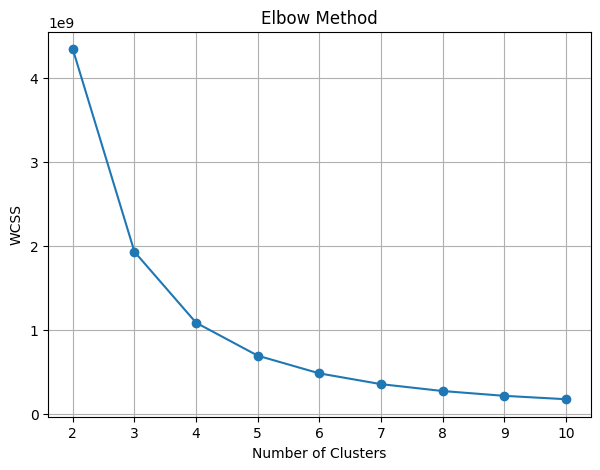

In [107]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(LRMFVD_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(K, wcss, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

### `Sillhoute`


k=2, Silhouette Score=0.6259

k=3, Silhouette Score=0.5895

k=4, Silhouette Score=0.5715

k=5, Silhouette Score=0.5613

k=6, Silhouette Score=0.5536

k=7, Silhouette Score=0.5486

k=8, Silhouette Score=0.5439

k=9, Silhouette Score=0.5415

k=10, Silhouette Score=0.5385

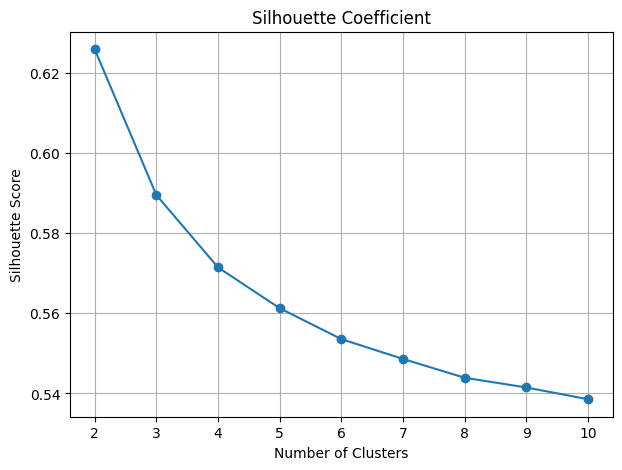

In [108]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(LRMFVD_df)
    sil_score = silhouette_score(LRMFVD_df, labels)
    silhouette_scores.append(sil_score)
    print(f"k={k}, Silhouette Score={sil_score:.4f}")

plt.figure(figsize=(7, 5))
plt.plot(K, silhouette_scores, marker="o")
plt.title("Silhouette Coefficient")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

### `DBI`


k=2, Davies-Bouldin Index=0.5010

k=3, Davies-Bouldin Index=0.5005

k=4, Davies-Bouldin Index=0.5001

k=5, Davies-Bouldin Index=0.4994

k=6, Davies-Bouldin Index=0.5000

k=7, Davies-Bouldin Index=0.5001

k=8, Davies-Bouldin Index=0.5003

k=9, Davies-Bouldin Index=0.5000

k=10, Davies-Bouldin Index=0.5005

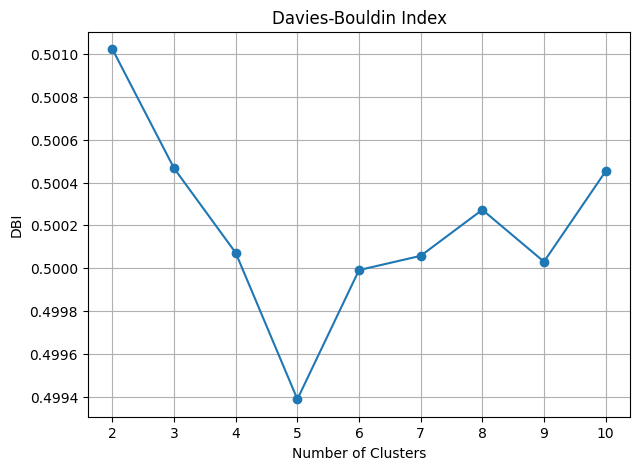

In [109]:
from sklearn.metrics import davies_bouldin_score

dbi_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(LRMFVD_df)
    dbi = davies_bouldin_score(LRMFVD_df, labels)
    dbi_scores.append(dbi)
    print(f"k={k}, Davies-Bouldin Index={dbi:.4f}")

plt.figure(figsize=(7, 5))
plt.plot(K, dbi_scores, marker="o")
plt.title("Davies-Bouldin Index")
plt.xlabel("Number of Clusters")
plt.ylabel("DBI")
plt.grid(True)
plt.show()

## K-Means


### load function


In [119]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(LRMFVD_df)
LRMFVD["Cluster_K5"] = clusters
col_F = LRMFVD_df.columns.get_loc("F")
col_M = LRMFVD_df.columns.get_loc("M")

,L,R,F,M,V,D_Afrika,D_America,D_Asia,D_Europe,D_Iceland,D_Other,D_UK,Cluster_ID,Customer ID
0,0.371483,0.272398,0.013211,0.004551,0.004225,0.00085,0.001699,0.000000,0.005947,0.00000,0.000000,0.991504,0.0000,NaN
1,0.368364,0.279621,0.013612,0.005155,0.004782,0.00000,0.003373,0.000843,0.003373,0.00000,0.000000,0.992411,1.0000,NaN
2,0.350894,0.260711,0.013498,0.005249,0.005150,0.00000,0.009458,0.019776,0.361135,0.00086,0.006879,0.592433,2.0000,NaN
3,0.373739,0.272243,0.012358,0.004158,0.004156,0.00000,0.000000,0.000000,0.001695,0.00000,0.000847,0.996610,3.0000,NaN
4,0.384123,0.272952,0.013915,0.005669,0.006462,0.00000,0.000000,0.000000,0.014468,0.00000,0.000851,0.984681,4.0000,NaN
Global Mean,0.369760,0.271623,0.013318,0.004956,0.004953,0.00017,0.002891,0.004081,0.076518,0.00017,0.001700,0.912430,1.9983,15314.674205


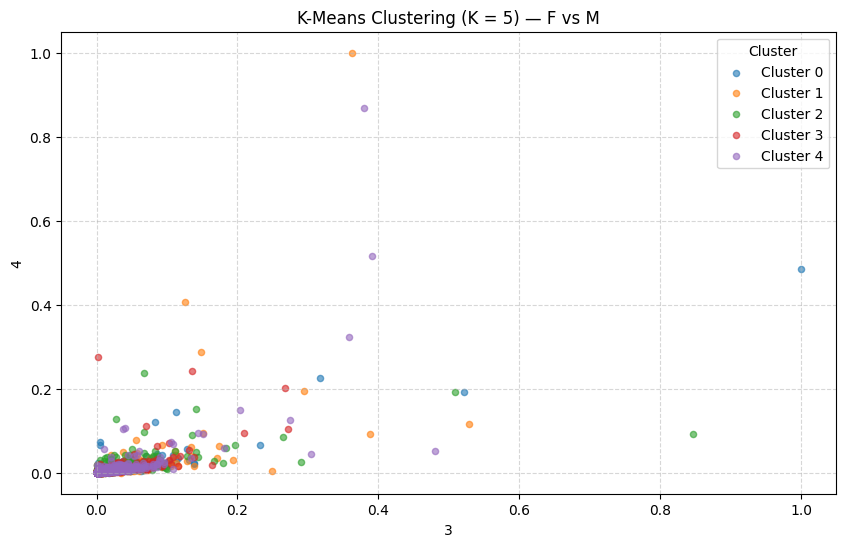

In [124]:
if not isinstance(clusters, pd.Series):
    clusters = pd.Series(clusters, name="Cluster_ID")
LRMFVD_df["Cluster_ID"] = clusters

cluster_centroids_scaled = LRMFVD_df.groupby(clusters).mean()
global_mean = LRMFVD_df.mean()
df_centroids = cluster_centroids_scaled.drop(columns=["Customer ID"])
df_global_mean = pd.DataFrame(global_mean).T
df_global_mean.index = ["Global Mean"]
df_profile = pd.concat([df_centroids, df_global_mean])
display(df_profile)
plt.figure(figsize=(10, 6))

unique_clusters = LRMFVD_df["Cluster_ID"].unique()
unique_clusters.sort()

for cluster_id in unique_clusters:
    # Filter DataFrame untuk klaster saat ini
    subset = LRMFVD_df[LRMFVD_df["Cluster_ID"] == cluster_id]

    # Plot subset data
    plt.scatter(
        subset["F"],
        subset["M"],
        label=f"Cluster {cluster_id}",  # Label untuk legend
        alpha=0.6,
        s=20,
    )

plt.title("K-Means Clustering (K = 5) — F vs M")
plt.xlabel(col_F)
plt.ylabel(col_M)
plt.legend(title="Cluster")  # Tampilkan legend
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
from sklearn.decomposition import PCA

x_col_name = "F"
y_col_name = "M"
X = LRMFVD.drop(columns=["Cluster_K5", "Customer ID"], errors="ignore").values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Buat DataFrame hasil PCA
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
pca_df["Cluster_K5"] = LRMFVD["Cluster_K5"].values


# # Visualisasi PCA
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(
#     pca_df["PC1"], pca_df["PC2"], c=pca_df["Cluster_K5"], cmap="viridis", s=50
# )
# plt.xlabel("Principal Component 1 (PC1)", fontsize=14)
# plt.ylabel("Principal Component 2 (PC2)", fontsize=14)
# plt.title("Visualisasi Klaster K-Means pada Sumbu PCA", fontsize=16)
# plt.legend(*scatter.legend_elements(), loc="upper right", title="Cluster")
# plt.grid(True, linestyle="--", alpha=0.6)
# # plt.show()

### Jumlah anggota cluster


In [ ]:
# jumlah anggota per cluster
display(LRMFVD["Cluster_K5"].value_counts())

Cluster_K5
1    1186
3    1180
0    1177
4    1175
2    1163
Name: count, dtype: int64

## K Prototype


### load function


In [ ]:
from kmodes.kprototypes import KPrototypes
import numpy as np
import pandas as pd

country_group_by_customer = retaildf.groupby("Customer ID")["Country_Group"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown"
)

feature_names = ["L", "R", "F", "M", "V"]
num_df = pd.DataFrame(Xscaled, columns=feature_names).copy()
num_df.index = country_group_by_customer.index

cat_df = country_group_by_customer.astype(str)

data_combined = np.column_stack([num_df.values, cat_df.values])
categorical_cols = [data_combined.shape[1] - 1]

k = 5
kproto = KPrototypes(n_clusters=k, init="Huang", random_state=42)
clusters = kproto.fit_predict(data_combined, categorical=categorical_cols)

num_df["Cluster_K5"] = clusters

### Jumlah anggota cluster


In [ ]:
# Jumlah anggota cluster
display(num_df["Cluster_K5"].value_counts())

Cluster_K5
2    1473
1    1271
3    1232
4    1202
0     703
Name: count, dtype: int64

In [ ]:
final_df = pd.concat([num_df, cat_df], axis=1)
final_df["Cluster_K5"] = clusters
final_df.rename(columns={"Country_Group": "D_Country_Group"}, inplace=True)

categorical_centroid = (
    final_df.groupby("Cluster_K5")["D_Country_Group"]
    .agg(lambda x: x.mode()[0] if not x.mode().empty else "N/A")
    .reset_index()
    .rename(columns={"Country_Group": "D_Mode"})
)

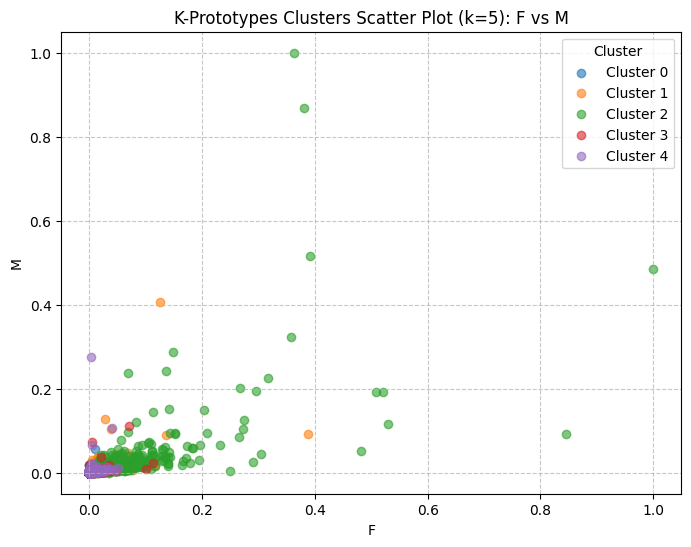

,Cluster,L,R,F,M,V,D_Country_Group
0,0,0.023926,0.826412,0.001265,0.000973,0.001710,UK
1,1,0.518390,0.158817,0.012372,0.004140,0.003935,UK
2,2,0.863899,0.049994,0.036207,0.013167,0.012958,UK
3,3,0.114779,0.516777,0.003414,0.001392,0.001530,UK
4,4,0.070662,0.086756,0.003468,0.001738,0.001626,UK
5,Global Mean,0.369760,0.271623,0.013318,0.004956,0.004953,NaN


In [ ]:
x_col = "F"
y_col = "M"

plt.figure(figsize=(8, 6))
clusters = num_df["Cluster_K5"].unique()
clusters.sort()

for cluster_id in clusters:
    subset = num_df[num_df["Cluster_K5"] == cluster_id]
    plt.scatter(subset[x_col], subset[y_col], label=f"Cluster {cluster_id}", alpha=0.6)

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"K-Prototypes Clusters Scatter Plot (k=5): {x_col} vs {y_col}")
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

centroid_df = num_df.groupby("Cluster_K5").mean().reset_index()
merged_centroid_df = pd.merge(centroid_df, categorical_centroid, on="Cluster_K5")

global_mean_series = num_df.mean(numeric_only=True)
global_mean_row = (
    global_mean_series.to_frame()
    .T[centroid_df.columns.drop("Cluster_K5").tolist()]
    .reset_index(drop=True)
)
global_mean_row["Cluster_K5"] = "Global Mean"
global_mean_row = global_mean_row[centroid_df.columns.tolist()]
final_table = pd.concat([merged_centroid_df, global_mean_row], ignore_index=True)
final_table.rename(columns={"Cluster_K5": "Cluster"}, inplace=True)

display(final_table)

In [ ]:
# x_col_name = "F"
# y_col_name = "M"
# X = num_df.values

# pca = PCA(n_components=2)
# principal_components = pca.fit_transform(X)

# # Buat DataFrame hasil PCA
# pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
# pca_df["Cluster_K5"] = num_df["Cluster_K5"].values

# # Tampilkan Variance Explained
# print(
#     f"Total Varian yang Dijelaskan oleh PC1 dan PC2: {pca.explained_variance_ratio_.sum():.2f}"
# )

# # # Visualisasi PCA
# # plt.figure(figsize=(10, 8))
# # scatter = plt.scatter(
# #     pca_df["PC1"], pca_df["PC2"], c=pca_df["Cluster_K5"], cmap="viridis", s=50
# # )
# # plt.xlabel("Principal Component 1 (PC1)", fontsize=14)
# # plt.ylabel("Principal Component 2 (PC2)", fontsize=14)
# # plt.title("Visualisasi Klaster K-Prototypes pada Sumbu PCA", fontsize=16)
# # plt.legend(*scatter.legend_elements(), loc="upper right", title="Cluster")
# # plt.grid(True, linestyle="--", alpha=0.6)
# # plt.show()

## Performance Evaluation


In [125]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

k = 5
kproto_clusters = num_df["Cluster_K5"].values  # Hasil K-Prototypes Anda

kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans_clusters = kmeans.fit_predict(num_df[["L", "R", "M", "F", "V"]])

ari_similarity = adjusted_rand_score(kproto_clusters, kmeans_clusters)
ami_similarity = adjusted_mutual_info_score(kproto_clusters, kmeans_clusters)

print(f"Adjusted Rand Index (ARI) Similarity:   {ari_similarity:.4f}")
print(f"Adjusted Mutual Information (AMI) Similarity: {ami_similarity:.4f}")

Adjusted Rand Index (ARI) Similarity:   0.9959

Adjusted Mutual Information (AMI) Similarity: 0.9925

# Cohort Analysis


In [ ]:
import pandas as pd
import numpy as np

retaildf["InvoiceDate"] = pd.to_datetime(retaildf["InvoiceDate"])


def get_month(x):
    return x.strftime("%Y-%m")


retaildf["InvoiceMonth"] = retaildf["InvoiceDate"].apply(get_month)

cohort_df = (
    retaildf.groupby("Customer ID")["InvoiceDate"].min().apply(get_month).reset_index()
)
cohort_df.columns = ["Customer ID", "CohortMonth"]
retaildf = retaildf.merge(cohort_df, on="Customer ID", how="left")


def get_cohort_index(df):
    invoice_ts = pd.to_datetime(df["InvoiceMonth"])
    cohort_ts = pd.to_datetime(df["CohortMonth"])
    year_diff = invoice_ts.year - cohort_ts.year
    month_diff = invoice_ts.month - cohort_ts.month

    return year_diff * 12 + month_diff


retaildf["CohortIndex"] = retaildf.apply(get_cohort_index, axis=1)

print("Dataframe dengan Kolom Kohort:")
print(retaildf[["Customer ID", "InvoiceMonth", "CohortMonth", "CohortIndex"]].head())

Dataframe dengan Kolom Kohort:

Customer ID InvoiceMonth CohortMonth  CohortIndex
0      13085.0      2009-12     2009-12            0
1      13085.0      2009-12     2009-12            0
2      13085.0      2009-12     2009-12            0
3      13085.0      2009-12     2009-12            0
4      13085.0      2009-12     2009-12            0

## Matrix


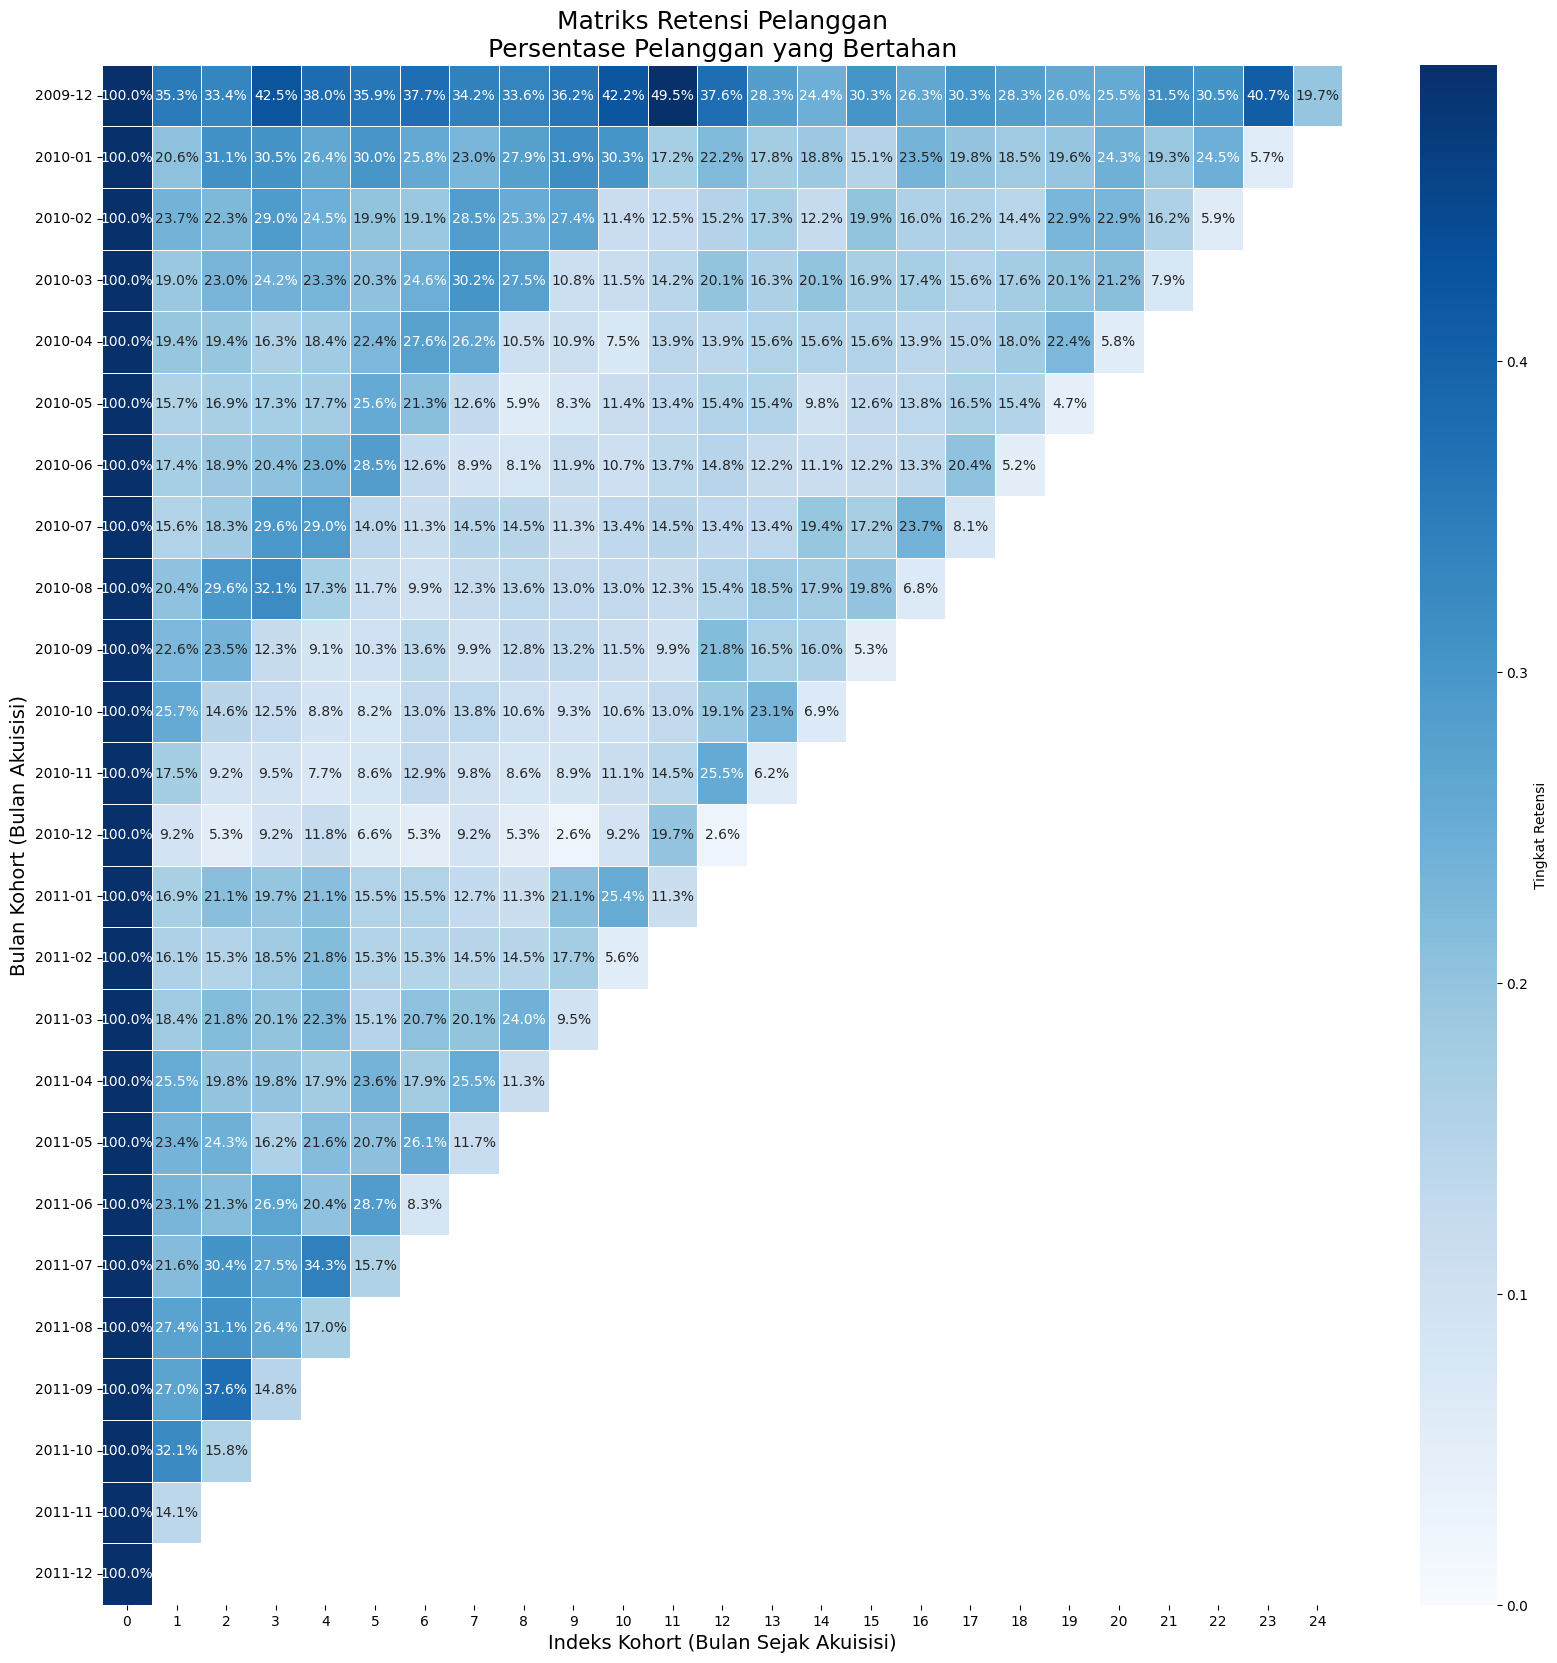

In [ ]:
cohort_data = (
    retaildf.groupby(["CohortMonth", "CohortIndex"])["Customer ID"]
    .nunique()
    .reset_index()
)

cohort_sizes = cohort_data[cohort_data["CohortIndex"] == 0].set_index("CohortMonth")[
    "Customer ID"
]

cohort_counts = cohort_data.pivot_table(
    index="CohortMonth", columns="CohortIndex", values="Customer ID"
)

retention_matrix = cohort_counts.divide(cohort_sizes, axis=0)

plt.figure(figsize=(20, 20))
plt.title(
    "Matriks Retensi Pelanggan\nPersentase Pelanggan yang Bertahan",
    fontsize=18,
)

sns.heatmap(
    retention_matrix,
    annot=True,
    fmt=".1%",
    cmap="Blues",
    vmin=0.0,
    vmax=retention_matrix.iloc[:, 1:].max().max(),
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Tingkat Retensi"},
)

plt.ylabel("Bulan Kohort (Bulan Akuisisi)", fontsize=14)
plt.xlabel("Indeks Kohort (Bulan Sejak Akuisisi)", fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()